# Characterizing the Impact of Active Queue Management (AQM) Algorithms on Data Transfers with Different Congestion Control Algorithms (CCAs)

### Topology

<img src="../AQM_CCA/files/topo.png" width="850px"><br>

# Step 1:  Configuring the environment

Before running this notebook, you will need to configure your environment using the [Configure Environment](../../../configure_and_validate.ipynb) notebook. Please stop here, open and run that notebook, then return to this notebook.

If you are using the FABRIC JupyterHub many of the environment variables will be automatically configured for you.  You will still need to set your bastion username, upload your bastion private key, and set the path to where you put your bastion private key. Your bastion username and private key should already be in your possession.  

If you are using the FABRIC API outside of the JupyterHub you will need to configure all of the environment variables. Defaults below will be correct in many situations but you will need to confirm your configuration.  If you have questions about this configuration, please contact the FABRIC admins using the [FABRIC User Forum](https://learn.fabric-testbed.net/forums/) 

More information about accessing your experiments through the FABRIC bastion hosts can be found [here](https://learn.fabric-testbed.net/knowledge-base/logging-into-fabric-vms/).

# Step 2: Importing the FABlib library

In [8]:
import json
import traceback
from fabrictestbed_extensions.fablib.fablib import fablib

# Step 3: Creating the experiment slice

The following creates a node with basic compute and networking capabilities. You build a slice by creating a new slice and adding resources to the slice. After you build the slice, you must submit a request for the slice to be instantiated.   

### 3.1 Configuring Slice Parameters

In [9]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network

# Slice 
slice_name = 'AQM_CCA'

#[site1,site2] = fablib.get_random_sites(count=2)
site1="WASH"
site2="LOSA"
print(f"Sites: {site1},{site2}")

# routeres
R1_name = "R1"
R2_name = "R2"

router_cores = 8
router_ram = 16
router_disk = 20

# Hosts
h1_name = "h1"
h2_name = "h2"

h1_subnet=IPv4Network('172.16.0.0/16')
h1_addr=IPv4Address('172.16.255.10')
R1_addr1=IPv4Address('172.16.255.254')

h2_subnet=IPv4Network('172.17.0.0/16')
h2_addr=IPv4Address('172.17.255.10')
R2_addr1=IPv4Address('172.17.255.254')

R1_subnet=IPv4Network('192.168.12.0/30')
R1_addr2=IPv4Address('192.168.12.1')

R2_subnet=IPv4Network('192.168.12.0/30')
R2_addr2=IPv4Address('192.168.12.2')

host_cores = 16
host_ram = 32
host_disk = 20

net_h1_name = 'net_h1'
net_h2_name = 'net_h2'

net_R1_R2_name = 'net_R1_R2'

# All node properties
image = 'default_ubuntu_24'

Sites: WASH,LOSA


### 3.2 Creating the Slice

This step takes around 3-4 minutes

In [10]:
try:
    #Create Slice
    slice = fablib.new_slice(name=slice_name)

    # Add router node R1
    R1 = slice.add_node(name=R1_name, site=site1,  image=image, 
                        cores=router_cores, ram=router_ram, disk=router_disk)
    R1.set_capacities(cores=router_cores, ram=router_ram, disk=router_disk)
    R1_iface_1 = R1.add_component(model='NIC_Basic', name="R1_router_nic1").get_interfaces()[0]
    R1_iface_2 = R1.add_component(model='NIC_Basic', name="R1_router_nic2").get_interfaces()[0]

     # Add router node R1
    R2 = slice.add_node(name=R2_name, site=site2,  image=image, 
                        cores=router_cores, ram=router_ram, disk=router_disk)
    R2.set_capacities(cores=router_cores, ram=router_ram, disk=router_disk)
    R2_iface_1 = R2.add_component(model='NIC_Basic', name="R2_router_nic1").get_interfaces()[0]
    R2_iface_2 = R2.add_component(model='NIC_Basic', name="R2_router_nic2").get_interfaces()[0]
    
    # Add host node h1
    h1 = slice.add_node(name=h1_name, site=site1, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h1_iface = h1.add_component(model='NIC_Basic', name="h1_nic").get_interfaces()[0]
    
    # Add host node h2
    h2 = slice.add_node(name=h2_name, site=site2, image=image,
                        cores=host_cores, ram=host_ram, disk=host_disk)
    h2_iface = h2.add_component(model='NIC_Basic', name="h2_nic").get_interfaces()[0]
    
    #Add host networks 
    host_net1 = slice.add_l2network(name=net_h1_name, interfaces=[h1_iface, R1_iface_1])
    router_net1 = slice.add_l2network(name=net_R1_R2_name, interfaces=[R1_iface_2, R2_iface_2])
    host_net2 = slice.add_l2network(name=net_h2_name, interfaces=[h2_iface, R2_iface_1])
    
    #Submit Slice Request
    slice.submit() 
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()


Retry: 8, Time: 207 sec


ID,4ac100c6-97bb-4a28-ba10-8f344a6f5148
Name,AQM_CCA
Lease Expiration (UTC),2026-01-31 00:53:32 +0000
Lease Start (UTC),2026-01-30 00:53:32 +0000
Project ID,8eaa3ec2-65e7-49a3-8c09-e1761141a6ad
State,StableOK
Email,jagomez@fortlewis.edu
UserId,b884fd22-4166-4c28-bb4d-ea7b81fb5f3c


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
6a2a9401-cbb5-4da5-bece-884eff83d9ad,R1,8,16,100,default_ubuntu_24,qcow2,wash-w1.fabric-testbed.net,WASH,ubuntu,2001:400:a100:3020:f816:3eff:fe51:f686,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe51:f686,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6b4c2842-5902-4341-9e73-7d30bf1be4c2,R2,8,16,100,default_ubuntu_24,qcow2,losa-w2.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fece:7f25,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fece:7f25,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
2ad63bad-c51c-4028-b7b9-c32d3d85ee75,h1,16,32,100,default_ubuntu_24,qcow2,wash-w1.fabric-testbed.net,WASH,ubuntu,2001:400:a100:3020:f816:3eff:fe8f:15c8,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe8f:15c8,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
45ef394c-3196-4df1-8190-a1722d43fce1,h2,16,32,100,default_ubuntu_24,qcow2,losa-w2.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fedc:9fd1,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fedc:9fd1,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
ba68549f-e06a-4ca9-81dd-9d6a08d0f848,net_R1_R2,L2,L2STS,None,None,None,Active,
f49fda9c-a927-4bed-90f1-710adbb2d3b1,net_h1,L2,L2Bridge,WASH,None,None,Active,
ff19f89b-793d-48bd-908b-866cb928f232,net_h2,L2,L2Bridge,LOSA,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
R1-R1_router_nic1-p1,p1,R1,net_h1,100,config,,02:2E:31:ED:BC:AA,enp7s0,enp7s0,fe80::2e:31ff:feed:bcaa,6,HundredGigE0/0/0/5
R1-R1_router_nic2-p1,p1,R1,net_R1_R2,100,config,,02:55:17:D3:66:1F,enp8s0,enp8s0,fe80::55:17ff:fed3:661f,6,HundredGigE0/0/0/5
R2-R2_router_nic2-p1,p1,R2,net_R1_R2,100,config,,1A:B8:E4:DB:34:62,enp6s0,enp6s0,fe80::18b8:e4ff:fedb:3462,4,HundredGigE0/0/0/7
R2-R2_router_nic1-p1,p1,R2,net_h2,100,config,,1E:88:E2:2F:D3:5D,enp7s0,enp7s0,fe80::1c88:e2ff:fe2f:d35d,4,HundredGigE0/0/0/7
h1-h1_nic-p1,p1,h1,net_h1,100,config,,02:E5:AE:88:45:C9,enp7s0,enp7s0,fe80::e5:aeff:fe88:45c9,6,HundredGigE0/0/0/5
h2-h2_nic-p1,p1,h2,net_h2,100,config,,26:D4:FB:4A:E2:EB,enp6s0,enp6s0,fe80::24d4:fbff:fe4a:e2eb,4,HundredGigE0/0/0/7



Time to print interfaces 214 seconds


### 3.3 Installing BBRv3 Kernel Module

In [11]:
h1 = slice.get_node(name="h1")     
h1.upload_file('kernel_module/linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.upload_file('kernel_module/linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb', 'linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb')
h1.execute("sudo dpkg -i linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("sudo dpkg -i linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb")
h1.execute("echo 'net.ipv4.tcp_congestion_control=bbr' | sudo tee -a /etc/sysctl.conf")
h1.execute("sudo rm *.deb")
h1.execute("sudo sysctl -p")
#h1.execute("sysctl net.ipv4.tcp_congestion_control")
h1.execute("sudo reboot")

Selecting previously unselected package linux-headers-6.4.0-bbrv3.
(Reading database ... 74797 files and directories currently installed.)
Preparing to unpack linux-headers-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-headers-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Selecting previously unselected package linux-image-6.4.0-bbrv3.
(Reading database ... 85045 files and directories currently installed.)
Preparing to unpack linux-image-6.4.0-bbrv3_6.4.0-g7542cc7c41c0-1_amd64.deb ...
Unpacking linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
Setting up linux-image-6.4.0-bbrv3 (6.4.0-g7542cc7c41c0-1) ...
update-initramfs: Generating /boot/initrd.img-6.4.0-bbrv3
Sourcing file `/etc/default/grub'
Sourcing file `/etc/default/grub.d/50-cloudimg-settings.cfg'
Generating grub configuration file ...
Found linux image: /boot/vmlinuz-6.8.0-63-generic
Found initrd image: /boot/initrd.img-6.8.0-63-generic
Found linux 

('', '')

### 3.4 Verifying the Kernel Module Installation

In [12]:
h1.execute("uname -a")
h1.execute("sysctl net.ipv4.tcp_available_congestion_control")

Linux h1 6.8.0-63-generic #66-Ubuntu SMP PREEMPT_DYNAMIC Fri Jun 13 20:25:30 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
net.ipv4.tcp_available_congestion_control = reno cubic bbr


('net.ipv4.tcp_available_congestion_control = reno cubic bbr\n', '')

# Step 4 Configuring Nodes

### 4.1 Configuring Updates and Packages

In [14]:
config_threads = {}

In [16]:
host_config_script = "sudo apt-get update -qq && sudo apt-get -y install && sudo apt-get -y install net-tools -qq && sudo apt-get -y install iperf3 -qq  && sudo apt-get -y install mininet -qq" 

try: 
    h1 = slice.get_node(name=h1_name)
    h1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h1/' /etc/hosts")
    if type(ip_address(h1.get_management_ip())) is IPv6Address:
        h1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    h1_os_iface = h1.get_interface(network_name=net_h1_name)
    h1_os_iface.ip_addr_add(addr=h1_addr, subnet=h1_subnet)
    h1_config_thread = h1.execute_thread(host_config_script)
    config_threads[h1] = h1_config_thread
    
    h2 = slice.get_node(name=h2_name)
    h2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost h2/' /etc/hosts")
    if type(ip_address(h2.get_management_ip())) is IPv6Address:
        h2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")
    h2_os_iface = h2.get_interface(network_name=net_h2_name)
    h2_os_iface.ip_addr_add(addr=h2_addr, subnet=h2_subnet)
    h2_config_thread = h2.execute_thread(host_config_script)
    config_threads[h2] = h2_config_thread

    R1 = slice.get_node(name=R1_name)  
    R1.execute("sudo sed -i '1s/.*/127.0.0.1 localhost R1/' /etc/hosts")
    if type(ip_address(R1.get_management_ip())) is IPv6Address:
        R1.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    R1_os_iface = R1.get_interface(network_name=net_h1_name)
    R1_os_iface.ip_addr_add(addr=R1_addr1, subnet=h1_subnet)
    R1_os_iface = R1.get_interface(network_name=net_R1_R2_name)
    R1_os_iface.ip_addr_add(addr=R1_addr2, subnet=R1_subnet)
    R1_config_thread = R1.execute_thread(host_config_script)
    config_threads[R1] = R1_config_thread

    R2 = slice.get_node(name=R2_name) 
    R2.execute("sudo sed -i '1s/.*/127.0.0.1 localhost R2/' /etc/hosts")
    if type(ip_address(R2.get_management_ip())) is IPv6Address:
        R2.execute("sudo sed -i '/nameserver/d' /etc/resolv.conf && sudo sh -c 'echo nameserver 2a00:1098:2c::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a01:4f8:c2c:123f::1 >> /etc/resolv.conf' && sudo sh -c 'echo nameserver 2a00:1098:2b::1 >> /etc/resolv.conf'")   
    R2_os_iface = R2.get_interface(network_name=net_h2_name)
    R2_os_iface.ip_addr_add(addr=R2_addr1, subnet=h2_subnet)   
    R2_os_iface = R2.get_interface(network_name=net_R1_R2_name)
    R2_os_iface.ip_addr_add(addr=R2_addr2, subnet=R2_subnet)
    R2_config_thread = R2.execute_thread(host_config_script)
    config_threads[R2] = R2_config_thread
    print("Packages and tools are now installed")

except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

Packages and tools are now installed


### 4.2 Installing Mininet

In [17]:
h1.execute("git clone https://github.com/mininet/mininet &> /dev/null")
h1.execute("cd mininet && git checkout master &> /dev/null")
h1.execute("sudo ./util/install.sh -a &> /dev/null")

h2.execute("git clone https://github.com/mininet/mininet &> /dev/null")
h2.execute("cd mininet && git checkout master &> /dev/null")
h2.execute("sudo ./util/install.sh -a &> /dev/null")


('', '')

### 4.3 Configuring Default Routes in h1 and h2 and Static Routes in R1 and R2

In [18]:
h1.execute("sudo ifconfig enp7s0 up")
h1.execute("sudo ip route add 172.17.0.0/16 via 172.16.255.254")
h2.execute("sudo ifconfig enp6s0 up")
h2.execute("sudo ip route add 172.16.0.0/16 via 172.17.255.254")

R1.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")
R2.execute("sudo sysctl -w net.ipv4.conf.all.forwarding=1")

R1.execute("sudo ip route add 172.17.0.0/16 via 192.168.12.2")
R2.execute("sudo ip route add 172.16.0.0/16 via 192.168.12.1")

net.ipv4.conf.all.forwarding = 1
net.ipv4.conf.all.forwarding = 1


('', '')

## 4.4 Set Router R1 buffer size

In [109]:
import re

def _to_text(output) -> str:
    """Convert FABRIC execute() output to a single text string."""
    if isinstance(output, (list, tuple)):
        return "\n".join(str(x) for x in output)
    return str(output)

def extract_avg_rtt_ms(ping_output) -> float:
    """
    Parse ping output and return avg RTT in ms.
    Handles Linux 'ping' summary lines like:
      rtt min/avg/max/mdev = 0.123/0.456/0.789/0.012 ms
      round-trip min/avg/max/stddev = ... ms
    """
    text = _to_text(ping_output)

    pattern = r"(?:rtt|round-trip).*=\s*([\d\.]+)/([\d\.]+)/([\d\.]+)/([\d\.]+)\s*ms"
    m = re.search(pattern, text)
    if not m:
        raise ValueError(f"Could not find RTT summary line. Output was:\n{text}")

    return float(m.group(2))  # avg

def measure_avg_rtt(R1, dst_ip="192.168.12.2", count=10) -> float:
    out = R1.execute(f"ping -c {count} {dst_ip}")
    return extract_avg_rtt_ms(out)

# Usage
avg = measure_avg_rtt(R1, "192.168.12.2", 10)
print(f"Average RTT: {avg:.3f} ms")

K_BDP = 1  # buffer size in BDP
base_rtt_ms = avg  # better: min RTT

latency_ms = K_BDP * base_rtt_ms
burst = "125k"     # good starting point for 10g (you can try 256k too)

R1.execute(f"sudo tc qdisc replace dev enp8s0 root tbf rate 10gbit burst {burst} latency {latency_ms}ms")

PING 192.168.12.2 (192.168.12.2) 56(84) bytes of data.
64 bytes from 192.168.12.2: icmp_seq=1 ttl=64 time=64.7 ms
64 bytes from 192.168.12.2: icmp_seq=2 ttl=64 time=64.4 ms
64 bytes from 192.168.12.2: icmp_seq=3 ttl=64 time=64.4 ms
64 bytes from 192.168.12.2: icmp_seq=4 ttl=64 time=64.4 ms
64 bytes from 192.168.12.2: icmp_seq=5 ttl=64 time=64.3 ms
64 bytes from 192.168.12.2: icmp_seq=6 ttl=64 time=64.4 ms
64 bytes from 192.168.12.2: icmp_seq=7 ttl=64 time=64.4 ms
64 bytes from 192.168.12.2: icmp_seq=8 ttl=64 time=64.3 ms
64 bytes from 192.168.12.2: icmp_seq=9 ttl=64 time=64.3 ms
64 bytes from 192.168.12.2: icmp_seq=10 ttl=64 time=64.4 ms

--- 192.168.12.2 ping statistics ---
10 packets transmitted, 10 received, 0% packet loss, time 9013ms
rtt min/avg/max/mdev = 64.310/64.386/64.675/0.098 ms
Average RTT: 64.386 ms


('', '')

### 4.3 Setting TCP Send and Receive Buffer Sizes in 

In [19]:
h1.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

h2.execute("sudo sysctl -w net.ipv4.tcp_wmem=\'1024 87380 200000000\'")
h1.execute("sudo sysctl -w net.ipv4.tcp_rmem=\'1024 87380 200000000\'")

net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000
net.ipv4.tcp_wmem = 1024 87380 200000000
net.ipv4.tcp_rmem = 1024 87380 200000000


('net.ipv4.tcp_rmem = 1024 87380 200000000\n', '')

# Step 5 Launching Mininet Topology in h1 and h2

In [27]:
num_hosts=16

In [28]:
#h1 = slice.get_node(name=h1_name)
#h2 = slice.get_node(name=h2_name)

h1.upload_file('scripts/topo_h1.py', 'topo_h1.py')
h2.upload_file('scripts/topo_h2.py', 'topo_h2.py')

#h1.execute('sudo mn -c &> /dev/null')
#h2.execute('sudo mn -c &> /dev/null')

h1.execute('mkdir results')
h2.execute('mkdir results')

#h1.execute(f'sudo python3 topo_h1.py {num_hosts} &')
#h2.execute(f'sudo python3 topo_h2.py {num_hosts} &')

mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘results’: File exists


('', 'mkdir: cannot create directory ‘results’: File exists\n')

### 3.4 Printing the Node SSH Commands

In [22]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node.get_name()}: {node.get_ssh_command()}")
except Exception as e:
    print(f"Exception: {e}")

R1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe51:f686
R2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fece:7f25
h1: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fe8f:15c8
h2: ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fedc:9fd1


### !!!Run the scripts manually in the VMS

In [23]:
print(f"Run the following command on h1: sudo python3 topo_h1.py {num_hosts}")
print(f"Run the following command on h2: sudo python3 topo_h2.py {num_hosts}")

Run the following command on h1: sudo python3 topo_h1.py 64
Run the following command on h2: sudo python3 topo_h2.py 64


## 5.1 Adding the VM's Port to router R1

In [29]:
h1.execute('sudo ovs-vsctl add-port s_agg1 enp7s0')#Interfaces are hardcoded
h2.execute('sudo ovs-vsctl add-port s_agg2 enp6s0')

('', '')

## 5.2 Configure static Routes in the Mininet hosts

In [30]:
for i in range(1, num_hosts + 1):
    print(f"Setting default route on host hs{i} and hr{i}")
    h1.execute(f"mininet/util/m hs{i} route add default gw 172.16.255.254 &> /dev/null")
    h2.execute(f"mininet/util/m hr{i} route add default gw 172.17.255.254 &> /dev/null")
print(f"Default routes configured in sender hosts (hs) and receiver hosts (hr)")

Setting default route on host hs1 and hr1
Setting default route on host hs2 and hr2
Setting default route on host hs3 and hr3
Setting default route on host hs4 and hr4
Setting default route on host hs5 and hr5
Setting default route on host hs6 and hr6
Setting default route on host hs7 and hr7
Setting default route on host hs8 and hr8
Setting default route on host hs9 and hr9
Setting default route on host hs10 and hr10
Setting default route on host hs11 and hr11
Setting default route on host hs12 and hr12
Setting default route on host hs13 and hr13
Setting default route on host hs14 and hr14
Setting default route on host hs15 and hr15
Setting default route on host hs16 and hr16
Default routes configured in sender hosts (hs) and receiver hosts (hr)


## 5.3 Populating the ARP tables in the Mininet Hosts

In [31]:
for i in range(1, num_hosts + 1):
    h1.execute(f"mininet/util/m hs{i} ping 172.17.0.{i} -c 1")
    h2.execute(f"mininet/util/m hr{i} ping 172.16.0.{i} -c 1")
print(f"ARP tables populated in sender hosts (hs) and receiver hosts (hr)")

PING 172.17.0.1 (172.17.0.1) 56(84) bytes of data.
64 bytes from 172.17.0.1: icmp_seq=1 ttl=62 time=126 ms

--- 172.17.0.1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 125.663/125.663/125.663/0.000 ms
PING 172.16.0.1 (172.16.0.1) 56(84) bytes of data.
64 bytes from 172.16.0.1: icmp_seq=1 ttl=62 time=61.0 ms

--- 172.16.0.1 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 60.960/60.960/60.960/0.000 ms
PING 172.17.0.2 (172.17.0.2) 56(84) bytes of data.
64 bytes from 172.17.0.2: icmp_seq=1 ttl=62 time=64.1 ms

--- 172.17.0.2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 64.085/64.085/64.085/0.000 ms
PING 172.16.0.2 (172.16.0.2) 56(84) bytes of data.
64 bytes from 172.16.0.2: icmp_seq=1 ttl=62 time=60.9 ms

--- 172.16.0.2 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 

## 5.4 Starting the iPerf3 Servers in h2

In [33]:
for i in range(1, num_hosts + 1):
    print(f"Starting iperf3 server on host hr{i}")
    h2.execute_thread(f"mininet/util/m hr{i} iperf3 -s")

Starting iperf3 server on host hr1
Starting iperf3 server on host hr2
Starting iperf3 server on host hr3
Starting iperf3 server on host hr4
Starting iperf3 server on host hr5
Starting iperf3 server on host hr6
Starting iperf3 server on host hr7
Starting iperf3 server on host hr8
Starting iperf3 server on host hr9
Starting iperf3 server on host hr10
Starting iperf3 server on host hr11
Starting iperf3 server on host hr12
Starting iperf3 server on host hr13
Starting iperf3 server on host hr14
Starting iperf3 server on host hr15
Starting iperf3 server on host hr16


## 5.5 Running the Test

### 5.5.1 Starting the iPerf3 clients

In [144]:
import time

def countdown(seconds: int, prefix: str = "iPerf running"):
    """Simple MM:SS countdown that updates on the same terminal line."""
    for remaining in range(seconds, 0, -1):
        mm, ss = divmod(remaining, 60)
        print(f"\r{prefix}: {mm:02d}:{ss:02d} remaining", end="", flush=True)
        time.sleep(1)
    print(f"\r{prefix}: 00:00 remaining")


transfer_duration = 39600
threads = []

# Start flows (recommended: do NOT add '&' if you want execute_thread to manage the lifecycle)
for i in range(1, num_hosts + 1):
    cmd = (
        f"mininet/util/m hs{i} "
        f"iperf3 -c 172.17.0.{i} -J -t {transfer_duration} "
        f"> results/hs{i}_out.json"
    )
    threads.append(h1.execute_thread(cmd))

# Visual timer while tests run
countdown(transfer_duration)

iPerf running: 00:00 remaining


### 5.2.2 Observe ss -tin ouput parsed

In [141]:
import re
import time

# -------------------- CONFIG --------------------
NUM_HOSTS   = 16
HOST_PREFIX = "hs"     # "hs" or "hr"
IPERF_PORT  = 5201     # set None to disable port filter
REFRESH_S   = 0.1
# -----------------------------------------------


# -------------------- EXEC (quiet if possible) --------------------
def exec_quiet(node, cmd):
    """
    Some FABRIC helpers support quiet/hide flags. Try them, otherwise fallback.
    """
    for kw in ("quiet", "hide", "suppress_output", "output"):
        try:
            if kw == "output":
                return node.execute(cmd, output=False)
            return node.execute(cmd, **{kw: True})
        except TypeError:
            pass
    return node.execute(cmd)


def _to_text(x):
    if isinstance(x, (tuple, list)):
        return "\n".join(str(p) for p in x if p is not None)
    return str(x)


# -------------------- PARSING HELPERS --------------------
def _find_int(text, key):
    m = re.search(rf"\b{key}:(\d+)\b", text)
    return int(m.group(1)) if m else None

def _find_float(text, key):
    m = re.search(rf"\b{key}:(\d+(?:\.\d+)?)\b", text)
    return float(m.group(1)) if m else None

def _find_rtt(text):
    # rtt:22.876/10.763
    m = re.search(r"\brtt:(\d+(?:\.\d+)?)/(\d+(?:\.\d+)?)\b", text)
    if not m:
        return None, None
    return float(m.group(1)), float(m.group(2))

def _find_rate_bps(text, key):
    # send 8988984bps, pacing_rate 22604480bps, delivery_rate 794488bps
    m = re.search(rf"\b{key}\s+(\d+)([KMG]?)bps\b", text)
    if not m:
        return None
    val = float(m.group(1))
    unit = m.group(2).upper()
    scale = {"": 1.0, "K": 1e3, "M": 1e6, "G": 1e9}[unit]
    return val * scale

def _find_bbr_bw_bps(text):
    # bbr:(bw:793952bps,mrtt:14.379,...)
    m = re.search(r"bbr:\(.*?\bbw:(\d+)([KMG]?)bps", text)
    if not m:
        return None
    val = float(m.group(1))
    unit = m.group(2).upper()
    scale = {"": 1.0, "K": 1e3, "M": 1e6, "G": 1e9}[unit]
    return val * scale

def _extract_ipport_tokens(header_line):
    parts = header_line.split()
    return [p for p in parts if ":" in p and re.search(r":\d+$", p)]

def _keep_port(src, dst, port):
    if port is None:
        return True
    return (src and src.endswith(f":{port}")) or (dst and dst.endswith(f":{port}"))


def parse_ss_tin_output(ss_text, port_filter=None):
    """
    Returns a list of flow dicts for ESTAB sockets.
    Each socket is usually two lines: ESTAB header + tcp info.
    """
    lines = [ln.strip() for ln in ss_text.splitlines() if ln.strip()]
    flows = []
    i = 0

    while i < len(lines):
        if not lines[i].startswith("ESTAB"):
            i += 1
            continue

        header = lines[i]
        info = lines[i + 1] if i + 1 < len(lines) else ""

        ipports = _extract_ipport_tokens(header)
        src = ipports[0] if len(ipports) >= 1 else None
        dst = ipports[1] if len(ipports) >= 2 else None

        if not _keep_port(src, dst, port_filter):
            i += 2
            continue

        tokens = info.split()
        cc = tokens[0] if tokens else None

        rtt_ms, _ = _find_rtt(info)

        flows.append({
            "src": src,
            "dst": dst,
            "cc": cc,
            "rtt_ms": rtt_ms,
            "minrtt_ms": _find_float(info, "minrtt"),
            "cwnd": _find_int(info, "cwnd"),
            "mss": _find_int(info, "mss"),
            "rto": _find_int(info, "rto"),              # usually ms (no unit)
            "bytes_acked": _find_int(info, "bytes_acked"),
            "send_bps": _find_rate_bps(info, "send"),
            "pacing_bps": _find_rate_bps(info, "pacing_rate"),
            "delivery_bps": _find_rate_bps(info, "delivery_rate"),
            "bbr_bw_bps": _find_bbr_bw_bps(info),
        })

        i += 2

    return flows


# -------------------- SUMMARIZATION --------------------
def mean(vals):
    vals = [v for v in vals if v is not None]
    return (sum(vals) / len(vals)) if vals else None

def sum_or_none(vals):
    vals = [v for v in vals if v is not None]
    return sum(vals) if vals else None

def bps_to_mbps(x):
    return None if x is None else (x / 1e6)

def fmt_float(x, w=9, p=2):
    return f"{'-':>{w}}" if x is None else f"{x:>{w}.{p}f}"

def fmt_int(x, w=6):
    return f"{'-':>{w}}" if x is None else f"{int(x):>{w}}"

def fmt_bps(x, w=12):
    # scientific keeps table narrow but still "bps"
    return f"{'-':>{w}}" if x is None else f"{x:>{w}.3e}"

def dominant_cc(ccs):
    ccs = [c for c in ccs if c]
    if not ccs:
        return "-"
    return max(set(ccs), key=ccs.count)

def summarize_host(flows, ack_rate_bps):
    send_bps = sum_or_none([f["send_bps"] for f in flows])
    pacing_bps = mean([f["pacing_bps"] for f in flows])
    delivery_bps = mean([f["delivery_bps"] for f in flows])
    bbr_bw_bps = mean([f["bbr_bw_bps"] for f in flows])

    return {
        "flows": len(flows),
        "cc": dominant_cc([f["cc"] for f in flows]),
        "avg_rtt": mean([f["rtt_ms"] for f in flows]),
        "min_rtt": mean([f["minrtt_ms"] for f in flows]),
        "avg_cwnd": mean([f["cwnd"] for f in flows]),
        "mss": mean([f["mss"] for f in flows]),
        "rto": mean([f["rto"] for f in flows]),
        # outgoing (from ss instantaneous rates)
        "send_mbps": bps_to_mbps(send_bps),
        "send_bps": send_bps,
        "pacing_mbps": bps_to_mbps(pacing_bps),
        "pacing_bps": pacing_bps,
        "delivery_mbps": bps_to_mbps(delivery_bps),
        "delivery_bps": delivery_bps,
        "bbr_bw_mbps": bps_to_mbps(bbr_bw_bps),
        "bbr_bw_bps": bbr_bw_bps,
        # incoming “ACK progress rate”: delta(bytes_acked)/dt * 8
        "ack_mbps": bps_to_mbps(ack_rate_bps),
        "ack_bps": ack_rate_bps,
    }


# -------------------- TABLE ONLY OUTPUT --------------------
def clear_only_table():
    # Best for notebooks; does not print extra text.
    try:
        from IPython.display import clear_output
        clear_output(wait=True)
    except Exception:
        print("\033[2J\033[H", end="")

def print_table(rows):
    header = (
        f"{'Host':<5} {'#F':>3} {'CC':<5} "
        f"{'RTT':>7} {'minRTT':>7} {'cwnd':>6} {'MSS':>5} {'RTO':>5} "
        f"{'Send(M)':>9} {'Send(bps)':>12} "
        f"{'ACK(M)':>9} {'ACK(bps)':>12} "
        f"{'Pace(M)':>9} {'Del(M)':>9} {'BBRbw(M)':>9}"
    )
    print(header)
    print("-" * len(header))

    for r in rows:
        print(
            f"{r['host']:<5} {r['flows']:>3} {r['cc']:<5} "
            f"{fmt_float(r['avg_rtt'],7,2)} {fmt_float(r['min_rtt'],7,2)} "
            f"{fmt_float(r['avg_cwnd'],6,1)} {fmt_int(r['mss'],5)} {fmt_float(r['rto'],5,0)} "
            f"{fmt_float(r['send_mbps'],9,2)} {fmt_bps(r['send_bps'],12)} "
            f"{fmt_float(r['ack_mbps'],9,2)} {fmt_bps(r['ack_bps'],12)} "
            f"{fmt_float(r['pacing_mbps'],9,2)} {fmt_float(r['delivery_mbps'],9,2)} {fmt_float(r['bbr_bw_mbps'],9,2)}"
        )


# -------------------- MAIN MONITOR LOOP --------------------
def monitor_ss_table(h1):
    prev_acked = {}  # host -> last total bytes_acked
    prev_time = {}   # host -> timestamp

    while True:
        rows = []
        now = time.time()

        for i in range(1, NUM_HOSTS + 1):
            host = f"{HOST_PREFIX}{i}"
            cmd = f"mininet/util/m {host} ss -tin"

            out = exec_quiet(h1, cmd)
            text = _to_text(out)
            flows = parse_ss_tin_output(text, port_filter=IPERF_PORT)

            # --- Incoming "ACK progress rate" (acked bytes per second) ---
            total_bytes_acked = sum_or_none([f["bytes_acked"] for f in flows]) or 0
            last_bytes = prev_acked.get(host, total_bytes_acked)
            last_t = prev_time.get(host, now)

            dt = max(1e-6, now - last_t)
            delta_bytes = max(0, total_bytes_acked - last_bytes)
            ack_rate_bps = (delta_bytes * 8.0) / dt  # bits/s

            prev_acked[host] = total_bytes_acked
            prev_time[host] = now

            summary = summarize_host(flows, ack_rate_bps)
            summary["host"] = host
            rows.append(summary)

        clear_only_table()
        print_table(rows)
        time.sleep(REFRESH_S)


# -------- Run in your notebook after h1 is defined --------
monitor_ss_table(h1)


Host   #F CC        RTT  minRTT   cwnd   MSS   RTO   Send(M)    Send(bps)    ACK(M)     ACK(bps)   Pace(M)    Del(M)  BBRbw(M)
------------------------------------------------------------------------------------------------------------------------------
hs1     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -         -         -
hs2     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -         -         -
hs3     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -         -         -
hs4     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -         -         -
hs5     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -         -         -
hs6     0 -           -       -      -     -     -         -            -      0.00    0.000e+00         -     

KeyboardInterrupt: 

### 5.2.2 Getting the JSON Files

In [107]:
for i in range(1, num_hosts + 1):
    h1.download_file(f"results/hs{i}_out.json",f"results/hs{i}_out.json")
print("JSON files are now ready for plotting!")

JSON files are now ready for plotting!


### 5.2.3 Save the JSON files in a ZIP file

In [152]:
#!/usr/bin/env python3
# Zip all .json files in ./results and move the zip to ./archived_experiments

from datetime import datetime
from pathlib import Path
from zipfile import ZipFile, ZIP_DEFLATED


# --- Paths (relative to where you run the script) ---
BASE_DIR = Path.cwd()                 # should be .../AQM_CCA when you run it there
RESULTS_DIR = BASE_DIR / "results"
ARCHIVE_DIR = BASE_DIR / "archived_experiments"

# --- Hardcode your label pieces here ---
EXP_NAME = "preliminary"
NUM_FLOWS = 16
CC_NAME = "bbr3"
BUF_BDP = K_BDP


def build_label() -> str:
    return f"{EXP_NAME}_{NUM_FLOWS}f_{CC_NAME}_{BUF_BDP}bdp"


def create_zip(label: str) -> Path:
    today = datetime.now().strftime("%Y%m%d")
    zip_path = RESULTS_DIR / f"{today}_{label}.zip"

    json_files = sorted(RESULTS_DIR.glob("*.json"))
    if not json_files:
        raise FileNotFoundError(f"No .json files found in {RESULTS_DIR.resolve()}")

    with ZipFile(zip_path, "w", compression=ZIP_DEFLATED) as zf:
        for f in json_files:
            zf.write(f, arcname=f.name)

    return zip_path


def move_to_archive(zip_path: Path) -> Path:
    if not ARCHIVE_DIR.is_dir():
        raise FileNotFoundError(f"Archive directory not found: {ARCHIVE_DIR.resolve()}")

    dest = ARCHIVE_DIR / zip_path.name
    return zip_path.replace(dest)   # move/rename


def main():
    label = build_label()

    zip_path = create_zip(label)
    archived_path = move_to_archive(zip_path)

    print(f"Archived zip: {archived_path}")


if __name__ == "__main__":
    main()


Archived zip: /home/fabric/work/AQM_CCA/archived_experiments/20260130_preliminary_16f_bbr3_1bdp.zip


# 6 Plotting the Results

## 6.1 Plot as a Function of Time

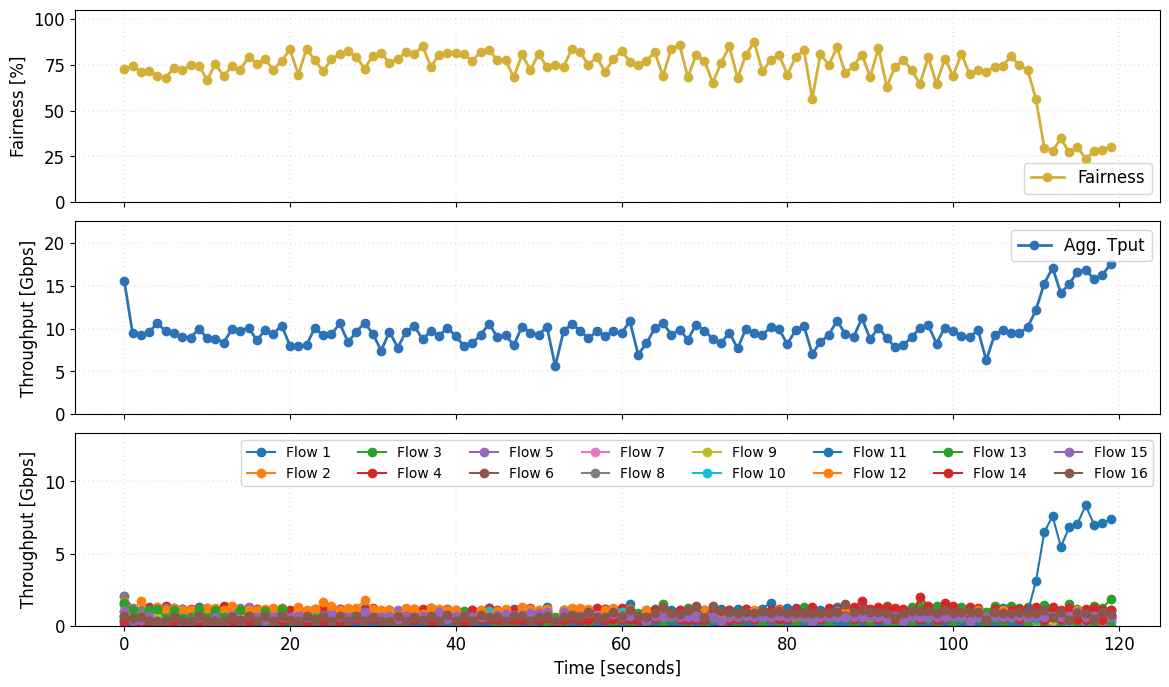

Saved PDF: /home/fabric/work/AQM_CCA/plots/20260130_preliminary_16f_bbr3_32bdp.pdf


In [151]:
import matplotlib.pyplot as plt
import numpy as np
import json
import matplotlib
import math
from datetime import datetime
from pathlib import Path

EXP_NAME = "preliminary"
CC_NAME  = "bbr3"
BUF_BDP  = 32

RESULTS_DIR = Path("results")
PLOTS_DIR   = Path("plots")   # <-- so it becomes AQM_CCA/plots (not AQM_CCA/AQM_CCA/plots)

def extract_iperf_timming(filename):
    with open(filename) as f:
        data = json.load(f)
    intervals = data.get("intervals", [])
    return [float(it["sum"]["bits_per_second"]) / 1e9 for it in intervals]

def setup_plot(font_size=12):
    font = {'family': 'normal', 'weight': 'normal', 'size': font_size}
    matplotlib.rc('font', **font)
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(14, 8))
    fig.subplots_adjust(hspace=0.1)
    for ax in axes:
        ax.grid(True, which="both", lw=0.3, linestyle=(0, (1, 10)), color='black')
    return fig, axes

def calculate_fairness(th_per_flow):
    th = np.asarray(th_per_flow, dtype=float)
    m, _ = th.shape
    sum_x = th.sum(axis=0)
    sum_x2 = (th ** 2).sum(axis=0)
    denom = m * sum_x2
    fairness = np.where(denom == 0, 100.0, 100.0 * (sum_x ** 2) / denom)
    return fairness.tolist()

def build_pdf_name():
    today = datetime.now().strftime("%Y%m%d")
    return f"{today}_{EXP_NAME}_{num_hosts}f_{CC_NAME}_{BUF_BDP}bdp.pdf"

def plot_results(throughput, th_per_flow, out_path):
    fairness = calculate_fairness(th_per_flow)
    fig, axes = setup_plot()

    N = len(throughput)
    t = list(range(N))

    axes[0].plot(t, fairness, '#D4AF37', linewidth=2, label='Fairness', marker='o')
    axes[1].plot(t, throughput, '#2D72B7', linewidth=2, label='Agg. Tput', marker='o')

    for flow_id, flow_series in enumerate(th_per_flow):
        axes[2].plot(t, flow_series[:N], linewidth=1.5, marker='o', label=f'Flow {flow_id+1}')

    axes[0].set_ylabel('Fairness [%]')
    axes[1].set_ylabel('Throughput [Gbps]')
    axes[2].set_ylabel('Throughput [Gbps]')
    axes[2].set_xlabel('Time [seconds]')

    axes[0].legend(loc="lower right")
    axes[1].legend(loc="upper right")

    num_flows = len(th_per_flow)
    items_per_col = 2
    ncol = max(1, math.ceil(num_flows / items_per_col))
    axes[2].legend(loc="upper right", ncol=ncol, fontsize=10, frameon=True)

    axes[0].set_ylim([0, 105])
    axes[1].set_ylim(0, float(np.max(throughput)) + 5)
    axes[2].set_ylim(0, float(np.max(th_per_flow)) + 5)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches='tight')

    # IMPORTANT: show BEFORE closing
    plt.show()
    plt.close(fig)

    print(f"Saved PDF: {out_path.resolve()}")

def main():
    th_per_flow = []
    for i in range(1, num_hosts + 1):
        th_per_flow.append(extract_iperf_timming(RESULTS_DIR / f"hs{i}_out.json"))

    N = min(len(x) for x in th_per_flow)
    th_per_flow = [x[:N] for x in th_per_flow]

    M = len(th_per_flow)
    agg_th = [0.0] * N
    for t in range(N):
        total = 0.0
        for flow in range(M):
            total += th_per_flow[flow][t]
        agg_th[t] = total

    out_pdf = PLOTS_DIR / build_pdf_name()
    plot_results(agg_th, th_per_flow, out_pdf)

if __name__ == '__main__':
    main()


# Step 5 Misc Scripts

### 5.1 Listing Available Sites

In [ ]:
try:
    print(f"{fablib.list_sites()}")
except Exception as e:
    print(f"Exception: {e}")

### 5.2 Printing Slice Attributes

In [25]:
try:
    slice = fablib.get_slice(name=slice_name)
    print(f"{slice}")
except Exception as e:
    print(f"Exception: {e}")

Exception: Unable to find slice "bbr3_test" for this project. Check slice name spelling and project id.


### 5.3 Printing the Node Attributes

In [6]:
try:
    slice = fablib.get_slice(name=slice_name)

    print(f"{slice.list_nodes()}")
except Exception as e:
    print(f"Exception: {e}")

Exception: Unable to find slice "bbr3_test" for this project. Check slice name spelling and project id.


### 5.4 Printing the Node Details

In [17]:
try:
    slice = fablib.get_slice(name=slice_name)
    for node in slice.get_nodes():
        print(f"{node}")
except Exception as e:
    print(f"Exception: {e}")

-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
ID                 ad27a133-66e0-4d2f-8676-63b91c1b9519
Name               R1
Cores              8
RAM                16
Disk               100
Image              default_ubuntu_24
Image Type         qcow2
Host               wash-w1.fabric-testbed.net
Site               WASH
Management IP      2001:400:a100:3020:f816:3eff:fecc:5861
Reservation State  Active
Error Message
SSH Command        ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3020:f816:3eff:fecc:5861
-----------------  --------------------------------------------------------------------------------------------------------------------------------------------
-----------------  -------------------------------------------------------------------------------------------------------------------------------

#### 5.5 Printing Interfaces

In [18]:
try:
    slice = fablib.get_slice(name=slice_name)
    
    print(f"{slice.list_interfaces()}")
except Exception as e:
    print(f"Exception: {e}")

Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
R1-R1_router_nic1-p1,p1,R1,net_h1,100,config,,0A:57:F2:E2:B1:4B,enp8s0,enp8s0,172.16.255.254,6,HundredGigE0/0/0/5
R1-R1_router_nic2-p1,p1,R1,net_R1_R2,100,config,,06:22:2B:9C:B0:45,enp7s0,enp7s0,192.168.12.1,6,HundredGigE0/0/0/5
R2-R2_router_nic1-p1,p1,R2,net_h2,100,config,,06:FE:5D:78:95:3D,enp7s0,enp7s0,172.17.255.254,4,HundredGigE0/0/0/9
R2-R2_router_nic2-p1,p1,R2,net_R1_R2,100,config,,06:BA:43:20:27:43,enp6s0,enp6s0,192.168.12.2,4,HundredGigE0/0/0/9
h1-h1_nic-p1,p1,h1,net_h1,100,config,,0A:95:62:56:90:8A,enp7s0,enp7s0,172.16.255.10,6,HundredGigE0/0/0/5
h2-h2_nic-p1,p1,h2,net_h2,100,config,,0A:03:50:C9:00:F2,enp6s0,enp6s0,172.17.255.10,4,HundredGigE0/0/0/9


### 5.6 Deleting a Slice

In [7]:
slice.delete()